<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D1_CNN5_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

# Function to map age to range index
def age_to_range(age, age_ranges):
    for idx, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return idx
    return 0

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [7]:
# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/Dataset/Dataset2/part1/'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for filename in os.listdir(image_dir):
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[0])
    range_index = age_to_range(age, age_ranges)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, len(age_ranges))

In [8]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (10137, 224, 224, 3)
Labels shape: (10137, 7)


In [9]:
def age_group_to_interval(group_index):
    if group_index < 0 or group_index >= len(age_ranges):
        return "Unknown"

    start, end = age_ranges[group_index]
    return f"{start}-{end}"

In [10]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/drive/MyDrive/Dataset/Dataset2/part1/...,46-65
1,/content/drive/MyDrive/Dataset/Dataset2/part1/...,28-45
2,/content/drive/MyDrive/Dataset/Dataset2/part1/...,46-65
3,/content/drive/MyDrive/Dataset/Dataset2/part1/...,46-65
4,/content/drive/MyDrive/Dataset/Dataset2/part1/...,28-45
5,/content/drive/MyDrive/Dataset/Dataset2/part1/...,28-45
6,/content/drive/MyDrive/Dataset/Dataset2/part1/...,21-27
7,/content/drive/MyDrive/Dataset/Dataset2/part1/...,28-45
8,/content/drive/MyDrive/Dataset/Dataset2/part1/...,21-27
9,/content/drive/MyDrive/Dataset/Dataset2/part1/...,66-116


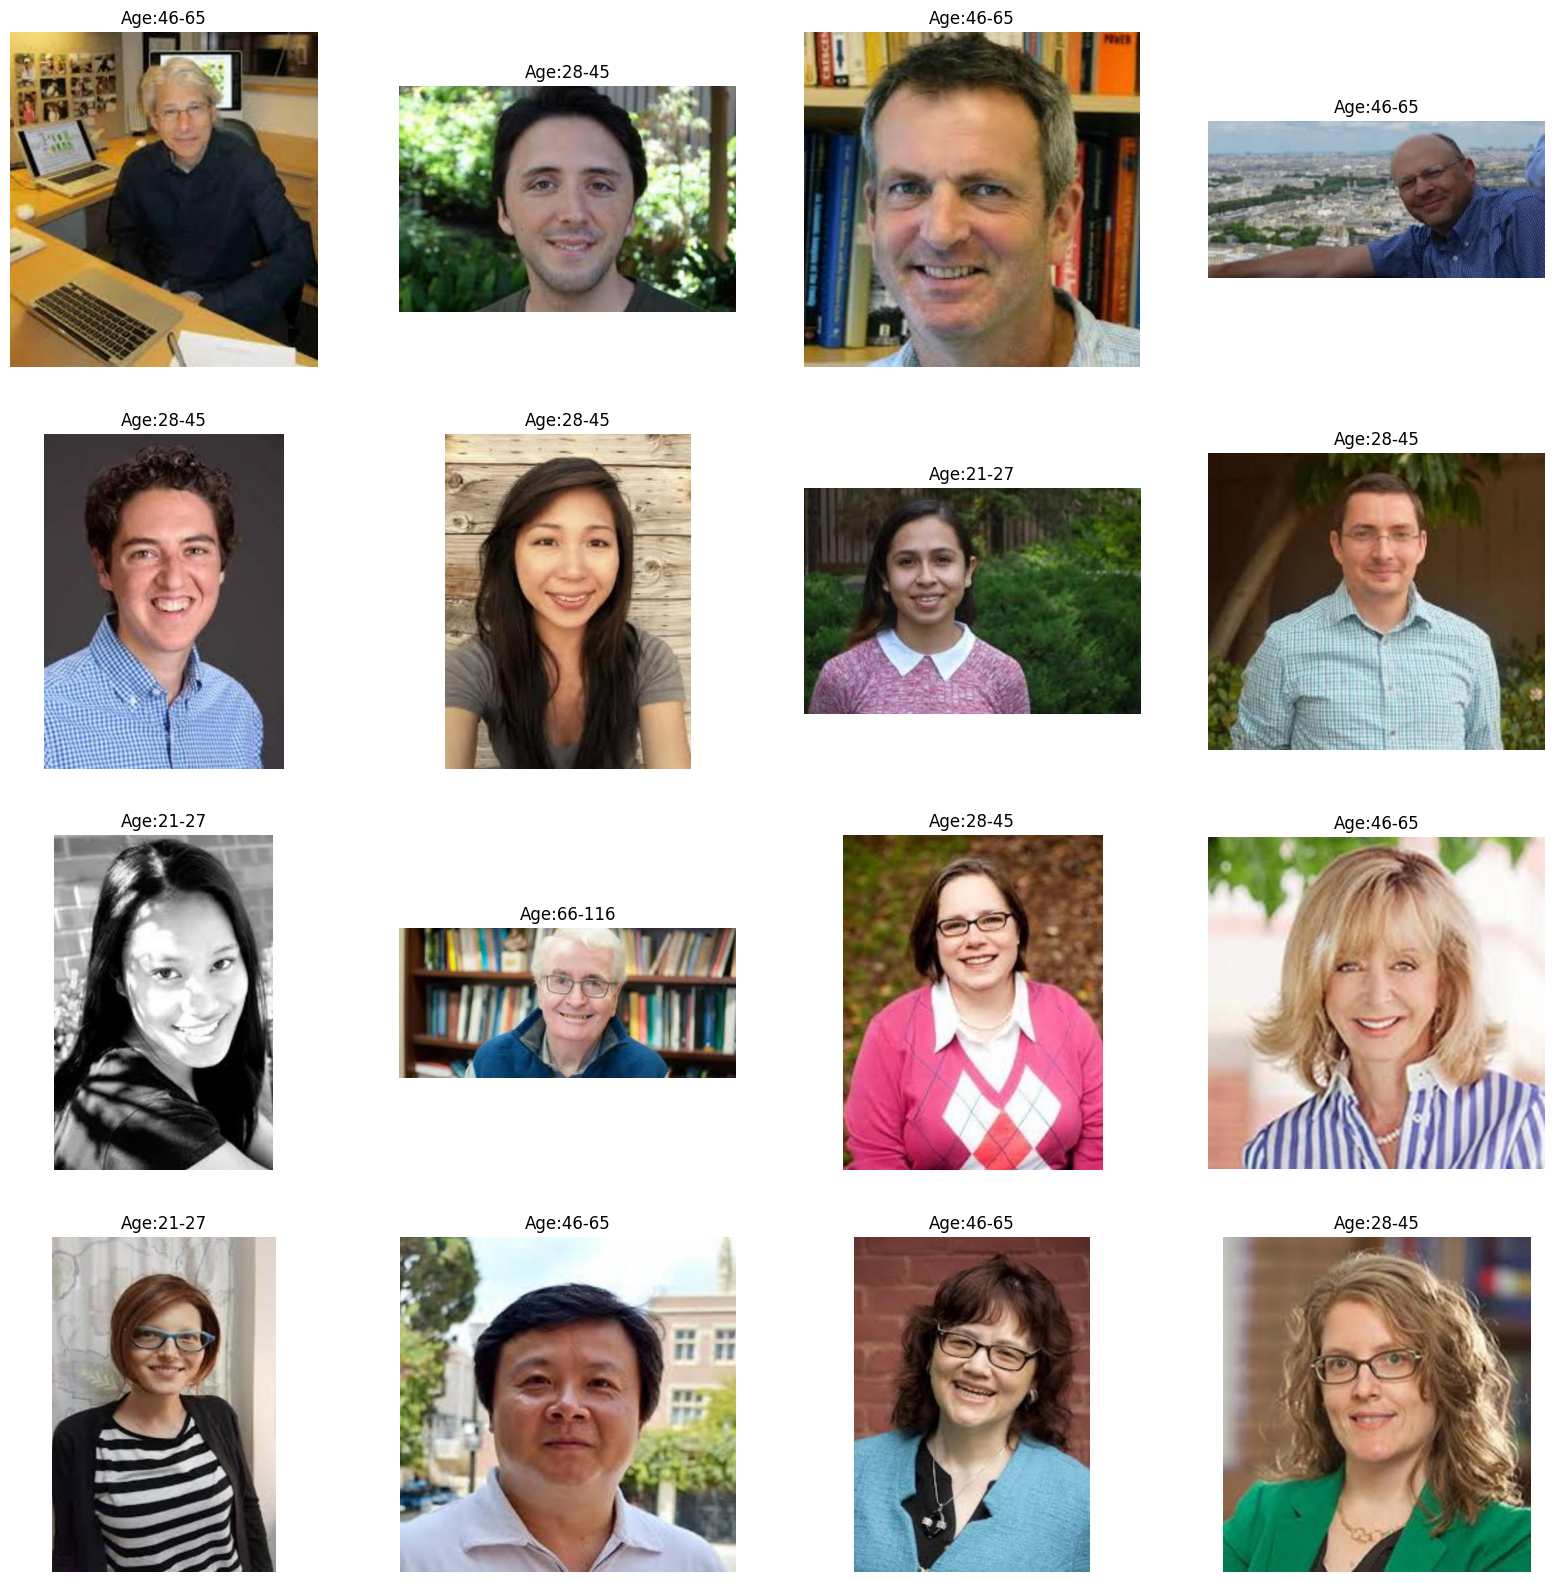

In [11]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

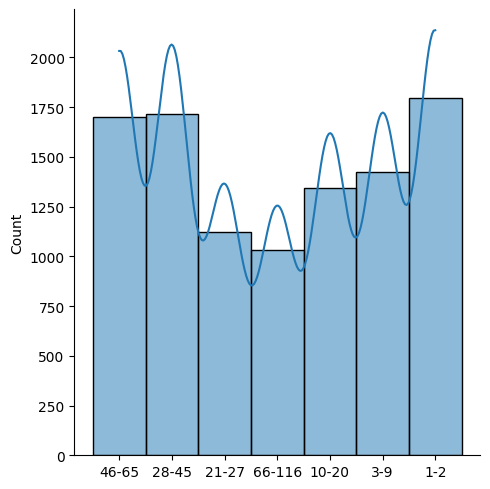

In [12]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [13]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.2, random_state=42)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
# Create training and validation generators
train_generator = datagen.flow(train_images, train_age_groups, batch_size=32, shuffle=False)  # Shuffle is False for reproducibility
val_generator = datagen.flow(test_images, test_age_groups, batch_size=32, shuffle=False)

In [16]:
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = keras.layers.Input(shape=[224, 224, 3]) # input is 192x192 pixels RGB

y = keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = keras.layers.GlobalAveragePooling2D()(y)
y = keras.layers.Dense(len(age_ranges), activation='softmax')(y)

model = keras.Model(x, y)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN5_A3_AUGMENT.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)


In [18]:
model.fit(train_generator, validation_data=val_generator, epochs=60, batch_size=32, callbacks=[early_stopping, model_checkpoint], shuffle=False)


Epoch 1/60
254/254 [==============================] - ETA: 0s - loss: 1.8009 - accuracy: 0.2783
Epoch 1: val_accuracy improved from -inf to 0.29487, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN5_A3_AUGMENT.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/254 [==============================] - 121s 410ms/step - loss: 1.8009 - accuracy: 0.2783 - val_loss: 1.7903 - val_accuracy: 0.2949
Epoch 2/60
254/254 [==============================] - ETA: 0s - loss: 1.7221 - accuracy: 0.3157
Epoch 2: val_accuracy did not improve from 0.29487
254/254 [==============================] - 100s 395ms/step - loss: 1.7221 - accuracy: 0.3157 - val_loss: 1.8813 - val_accuracy: 0.2416
Epoch 3/60
254/254 [==============================] - ETA: 0s - loss: 1.6827 - accuracy: 0.3359
Epoch 3: val_accuracy improved from 0.29487 to 0.32446, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN5_A3_AUGMENT.h5
254/254 [==============================] - 102s 401ms/step - loss: 1.6827 - accuracy: 0.3359 - val_loss: 1.7064 - val_accuracy: 0.3245
Epoch 4/60
254/254 [==============================] - ETA: 0s - loss: 1.6494 - accuracy: 0.3510
Epoch 4: val_accuracy did not improve from 0.32446
254/254 [==============================] - 101s 398ms/ste

In [19]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_CNN5_A3_AUGMENT.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


64/64 [==============================] - 3s 45ms/step - loss: 1.2252 - accuracy: 0.5261
Test Accuracy: 52.61%


In [20]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

64/64 [==============================] - 3s 44ms/step


In [21]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       335
           1       0.43      0.56      0.49       262
           2       0.43      0.40      0.42       289
           3       0.48      0.33      0.39       224
           4       0.53      0.53      0.53       353
           5       0.47      0.49      0.48       357
           6       0.50      0.53      0.52       208

    accuracy                           0.53      2028
   macro avg       0.52      0.52      0.51      2028
weighted avg       0.53      0.53      0.52      2028



In [22]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.53
Precision: 0.53
Recall: 0.53
F1-score: 0.52


In [23]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

In [24]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-2: 0.78
Accuracy for age range 3-9: 0.56
Accuracy for age range 10-20: 0.40
Accuracy for age range 21-27: 0.33
Accuracy for age range 28-45: 0.53
Accuracy for age range 46-65: 0.49
Accuracy for age range 66-116: 0.53


In [25]:
from sklearn.metrics import confusion_matrix
# Detailed classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=[f'{start}-{end}' for start, end in age_ranges]))

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

         1-2       0.81      0.78      0.79       335
         3-9       0.43      0.56      0.49       262
       10-20       0.43      0.40      0.42       289
       21-27       0.48      0.33      0.39       224
       28-45       0.53      0.53      0.53       353
       46-65       0.47      0.49      0.48       357
      66-116       0.50      0.53      0.52       208

    accuracy                           0.53      2028
   macro avg       0.52      0.52      0.51      2028
weighted avg       0.53      0.53      0.52      2028


Confusion Matrix:
[[261  60   5   2   3   1   3]
 [ 52 146  38   8   2   9   7]
 [  4  78 116  29  32  26   4]
 [  2  16  38  73  62  26   7]
 [  3  11  21  33 187  81  17]
 [  0  14  29   6  63 174  71]
 [  2  15  20   0   6  55 110]]
